# Imports

In [1]:
from sklearn.cluster import DBSCAN
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn import metrics

<br></br>
***
***
<br></br>

# Read CSV

In [2]:
penguins = pd.read_csv("2021-11-ml-09-k-means-animals-dataset.csv")
penguins.head()

,Region,Stage,Individual ID,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,Anvers,"Adult, 1 Egg Stage",N1A1,39.1,18.7,181.0,3750.0,NaN,NaN,Not enough blood for isotopes.
1,Anvers,"Adult, 1 Egg Stage",N1A2,39.5,17.4,186.0,3800.0,8.94956,-24.69454,NaN
2,Anvers,"Adult, 1 Egg Stage",N2A1,40.3,18.0,195.0,3250.0,8.36821,-25.33302,NaN
3,Anvers,"Adult, 1 Egg Stage",N2A2,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,Anvers,"Adult, 1 Egg Stage",N3A1,36.7,19.3,193.0,3450.0,8.76651,-25.32426,NaN


<br></br>
***
***
<br></br>

# DEA (Data Exploritory Analysis)

### Check for NaN values in each column.

In [3]:
penguins.isnull().sum()

Region                   0
Stage                    0
Individual ID            0
Culmen Length (mm)       2
Culmen Depth (mm)        2
Flipper Length (mm)      2
Body Mass (g)            2
Delta 15 N (o/oo)       14
Delta 13 C (o/oo)       13
Comments               318
dtype: int64

### Seaborn pairplot to understand general overview of dataset with relational scatter plots of all numerical columns and histographs going over counts of values in each colum.

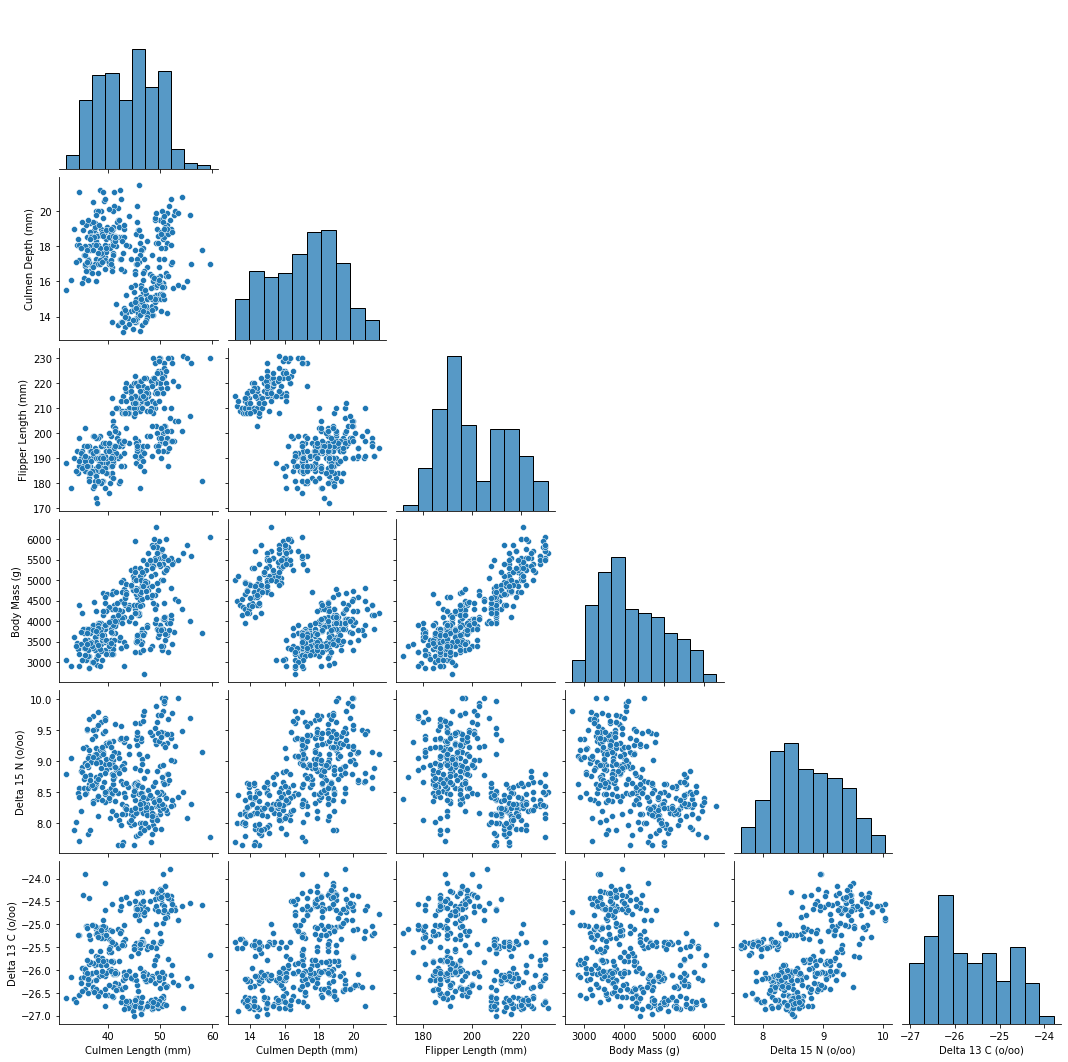

In [4]:
sns.pairplot(penguins, corner=True)

### Outlier detection of all numeric columns in dataset.

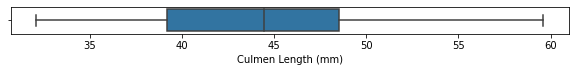

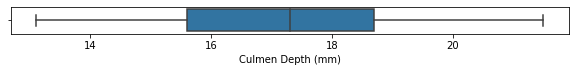

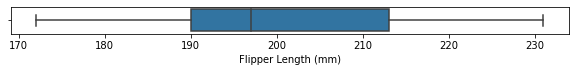

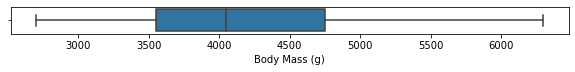

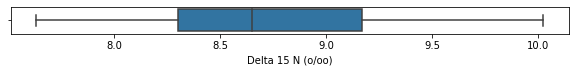

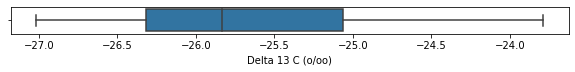

In [5]:
# outlier detection
penguins_numerical =penguins.select_dtypes(exclude=['object'])
for column in penguins_numerical:
    plt.figure(figsize=(10,0.5))
    sns.boxplot(data=penguins_numerical, x=column)

<br></br>
***
***
<br></br>

# Data Cleaning

### Remove 'Comments' column as it is nearly all NaNs.

In [6]:
penguins = penguins.drop("Comments", axis=1)

### Remove any rows in the dataset that have more the 50% NaNs in the row.

In [7]:
print("Before:", penguins.shape[0])
min_count = 0.5* penguins.shape[1]
penguins = penguins.dropna(axis=0, thresh = min_count)
print("After:", penguins.shape[0])
penguins.info()

Before: 344
After: 342
<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Region               342 non-null    object 
 1   Stage                342 non-null    object 
 2   Individual ID        342 non-null    object 
 3   Culmen Length (mm)   342 non-null    float64
 4   Culmen Depth (mm)    342 non-null    float64
 5   Flipper Length (mm)  342 non-null    float64
 6   Body Mass (g)        342 non-null    float64
 7   Delta 15 N (o/oo)    330 non-null    float64
 8   Delta 13 C (o/oo)    331 non-null    float64
dtypes: float64(6), object(3)
memory usage: 26.7+ KB


### Impute on columns 'Delta 15 N (o/oo)' and 'Delta 13 C (o/oo)' for NaN values using the median

In [8]:
imputer_continuos = SimpleImputer(missing_values=np.nan, strategy="median")

penguins["Delta 15 N (o/oo)"] = imputer_continuos.fit_transform(penguins["Delta 15 N (o/oo)"].values.reshape(-1,1))[:,0]
penguins["Delta 13 C (o/oo)"] = imputer_continuos.fit_transform(penguins["Delta 13 C (o/oo)"].values.reshape(-1,1))[:,0]
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Region               342 non-null    object 
 1   Stage                342 non-null    object 
 2   Individual ID        342 non-null    object 
 3   Culmen Length (mm)   342 non-null    float64
 4   Culmen Depth (mm)    342 non-null    float64
 5   Flipper Length (mm)  342 non-null    float64
 6   Body Mass (g)        342 non-null    float64
 7   Delta 15 N (o/oo)    342 non-null    float64
 8   Delta 13 C (o/oo)    342 non-null    float64
dtypes: float64(6), object(3)
memory usage: 26.7+ KB


### Look into both 'Region' and 'Stage' column values to see if this categorical data would be worth turning into dummy columns to better improve the algorithm used later on.

In [9]:
print(penguins["Region"].unique())
print(penguins["Stage"].unique())

['Anvers']
['Adult, 1 Egg Stage']


### All values in 'Region' and 'Stage' only show one label making them identifiers for what is likly a larger database encompassing animals, so let's remove them for the dataset as they won't impove our algorithm's learning ability later on.

In [10]:
penguins = penguins.drop(["Region", "Stage", "Individual ID"] , axis=1)

### Check cleaned dataset to make sure there are no NaNs and only numerical data remaining.

In [11]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Culmen Length (mm)   342 non-null    float64
 1   Culmen Depth (mm)    342 non-null    float64
 2   Flipper Length (mm)  342 non-null    float64
 3   Body Mass (g)        342 non-null    float64
 4   Delta 15 N (o/oo)    342 non-null    float64
 5   Delta 13 C (o/oo)    342 non-null    float64
dtypes: float64(6)
memory usage: 18.7 KB


<br></br>
***
***
<br></br>

# Take cleaned Data and standardize it using sklearn's StandardScaler() function

In [12]:
# Standardize data (0 mean, 1 stdev)
def StandardizeDataFrame(df):
    scaler = StandardScaler().fit(df)
    nested_list = scaler.transform(df)
    return nested_list

In [13]:
def CreateDataFrame(nested_list):
    columns = len(nested_list[0])
    headers = []
    for i in range(1, columns+1):
        headers.append(f'Column {i}')
    df = pd.DataFrame(nested_list, columns=headers)
    return df

In [14]:
penguins = penguins.copy()
penguins = CreateDataFrame(StandardizeDataFrame(penguins))
penguins.head()

,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6
0,-0.884499,0.785449,-1.418347,-0.564142,-0.144325,-0.182604
1,-0.811126,0.126188,-1.062250,-0.501703,0.404553,1.276990
2,-0.664380,0.430462,-0.421277,-1.188532,-0.669263,0.458783
3,-1.324737,1.089724,-0.563715,-0.938776,0.066440,0.470009
4,-0.847812,1.748985,-0.777373,-0.689020,-0.121134,0.503597


### Look over general statistics of new standarized data

In [15]:
penguins.describe()

,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6
count,3.420000e+02,3.420000e+02,3.420000e+02,3.420000e+02,3.420000e+02,3.420000e+02
mean,-9.024620e-17,-1.884782e-15,-4.875892e-16,9.414172e-17,-1.243969e-15,8.537680e-17
std,1.001465e+00,1.001465e+00,1.001465e+00,1.001465e+00,1.001465e+00,1.001465e+00
min,-2.168526e+00,-2.054446e+00,-2.059320e+00,-1.875362e+00,-2.028753e+00,-1.701198e+00
25%,-8.615697e-01,-7.866355e-01,-7.773731e-01,-8.138982e-01,-7.843473e-01,-7.743457e-01
50%,9.686524e-02,7.547549e-02,-2.788381e-01,-1.895079e-01,-1.443245e-01,-1.826038e-01
75%,8.397670e-01,7.854492e-01,8.606705e-01,6.846384e-01,7.586618e-01,7.816905e-01
max,2.875868e+00,2.205397e+00,2.142618e+00,2.620248e+00,2.391819e+00,2.439138e+00


<br></br>
***
***
<br></br>

# Plotting DBScan function

In [16]:
sns.set_theme(style="whitegrid")
def DBScan_Plot_2D(dataframe, epsilon = 0.5, minimum_samples = 5):
        pca = PCA(2)
        df = pca.fit_transform(dataframe)

        db = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit(df) 
        label = db.labels_
        u_labels = np.unique(label)
        fig = plt.figure(figsize=(10, 10))
        for i in u_labels:
                plt.scatter(df[label == i,0], df[label == i, 1], label = i)
        plt.title(f"\nClusters; eplison: {epsilon}, min_samples: {minimum_samples}\n", fontsize = 20)
        plt.legend()
        plt.show()
        return db

In [17]:
def CalculateSilhouetteScore(DBScan_return, df):
    labels = DBScan_return.labels_
    # measure the performance of dbscan algo
    #Identifying which points make up our “core points”
    core_samples = np.zeros_like(labels, dtype=bool)
    core_samples[DBScan_return.core_sample_indices_] = True
    #Calculating "the number of clusters"
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #Computing "the Silhouette Score"
    if(n_clusters_ == 1 or n_clusters_ == 0):
        print("Silhouette Coefficient: Cannot calculate, lacking clusters")
    else:
        print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, labels))

## General plots using default values

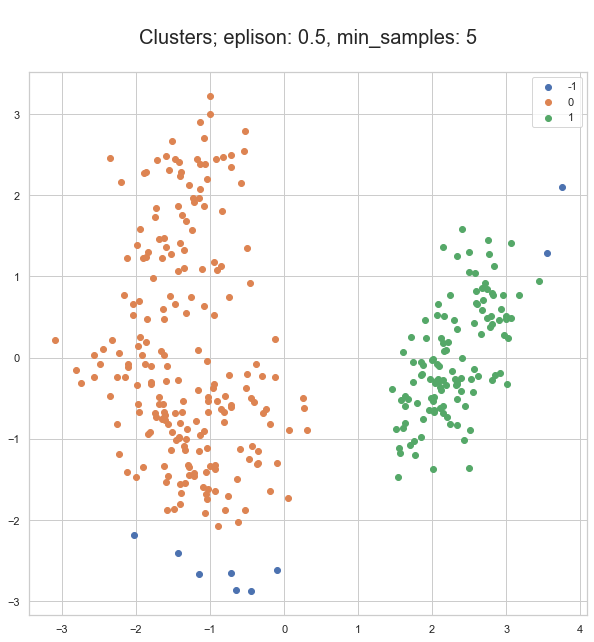

Silhouette Coefficient: 0.391


In [18]:
# Default
epsilon = 0.5; minimum_samples = 5
DBScan_return = DBScan_Plot_2D(penguins, epsilon, minimum_samples)
CalculateSilhouetteScore(DBScan_return, penguins)


<br></br>
***
***
<br></br>

## Hyper tuning: **min_samples**, slight improvement on minimum samples based on numerious online sites (will specify were at a later date)

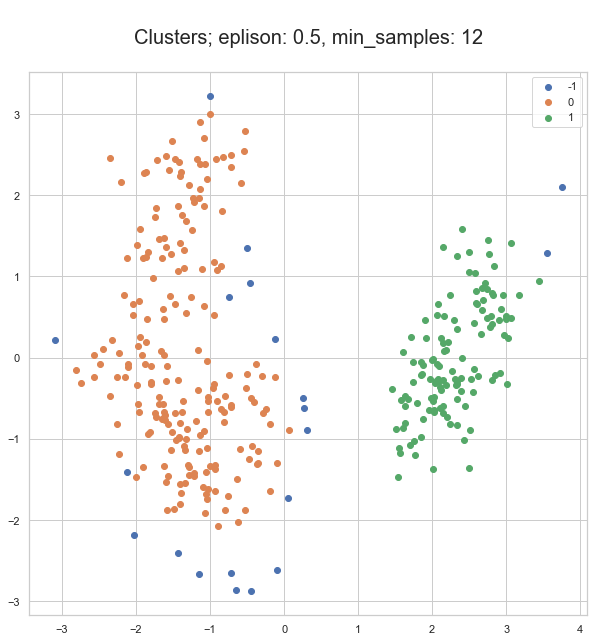

Silhouette Coefficient: 0.317


In [19]:
# Improved min_samples, number of features * 2, known as best
epsilon = 0.5; minimum_samples = penguins.shape[1] *2
DBScan_return = DBScan_Plot_2D(penguins, epsilon, minimum_samples)
CalculateSilhouetteScore(DBScan_return, penguins)

<br></br>
***
***
<br></br>

# Hyper Tuning: **epsilon**, based on k-Nearest-neighborhood algorithm

In [20]:
penguins_hypertune_epsilon = penguins.copy()
minimum_samples = 4
k = minimum_samples if minimum_samples > 2 else 2
nbrs = NearestNeighbors(n_neighbors=k).fit(penguins_hypertune_epsilon)
distances, indices = nbrs.kneighbors(penguins_hypertune_epsilon)

In [21]:
print(f"min_samples: {minimum_samples}")
print(f"Shape of distances matrix: {distances.shape}\n")
for enum, row in enumerate(distances[:5]):
    print(f"Observation {enum}: {[round(x,2) for x in row]}")

min_samples: 4
Shape of distances matrix: (342, 4)

Observation 0: [0.0, 0.52, 0.57, 0.63]
Observation 1: [0.0, 0.93, 0.95, 1.01]
Observation 2: [0.0, 0.81, 1.05, 1.15]
Observation 3: [0.0, 0.66, 0.9, 0.94]
Observation 4: [0.0, 0.79, 0.9, 0.98]


In [22]:
penguins_hypertune_epsilon["knn_farthest_dist"] = distances[:, -1]
penguins_hypertune_epsilon.head()

,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,knn_farthest_dist
0,-0.884499,0.785449,-1.418347,-0.564142,-0.144325,-0.182604,0.633425
1,-0.811126,0.126188,-1.062250,-0.501703,0.404553,1.276990,1.012754
2,-0.664380,0.430462,-0.421277,-1.188532,-0.669263,0.458783,1.148401
3,-1.324737,1.089724,-0.563715,-0.938776,0.066440,0.470009,0.940803
4,-0.847812,1.748985,-0.777373,-0.689020,-0.121134,0.503597,0.984260


### Sorted k-distance graph

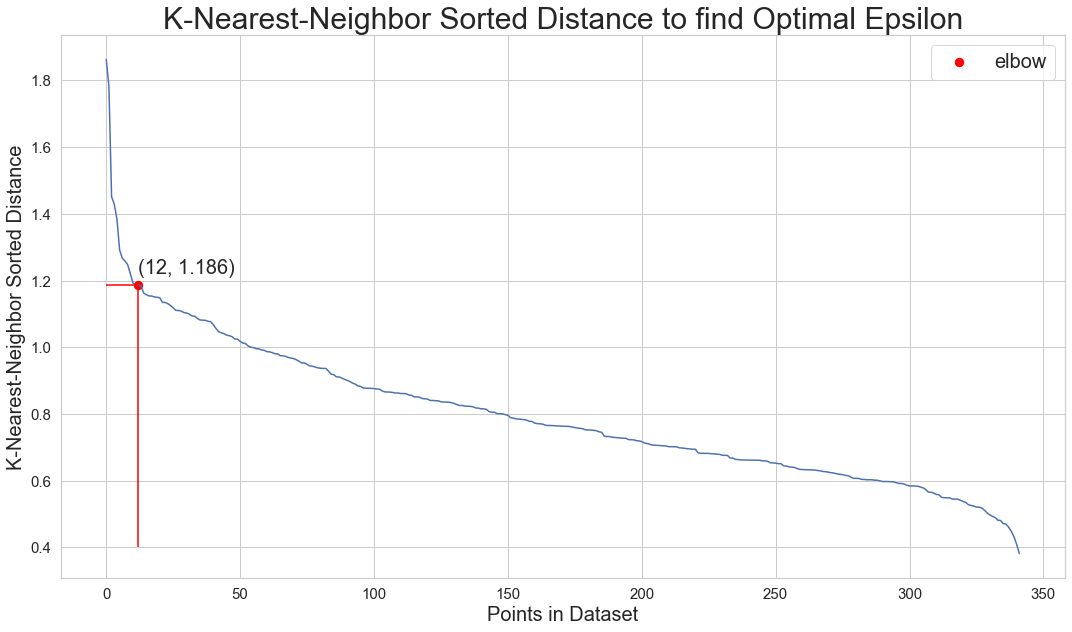

In [23]:
penguins_hypertune_epsilon = penguins_hypertune_epsilon.sort_values(by="knn_farthest_dist", ascending=False).reset_index()[["knn_farthest_dist"]]
plt.figure(figsize=(18, 10))
plt.plot(penguins_hypertune_epsilon)
#plt.scatter(penguins_hypertune_epsilon.index, penguins_hypertune_epsilon.knn_farthest_dist)
plt.xlabel("Points in Dataset", fontsize=20)
plt.ylabel("K-Nearest-Neighbor Sorted Distance",fontsize=20)
plt.vlines(x = 12, ymin = .4, ymax = 1.1868543631364483,
           colors = 'red')
plt.hlines(y = 1.1868543631364483, xmin = 0, xmax = 12,
           colors = 'red')
plt.scatter(x= 12, y= 1.1868543631364483, color = "red", s = 70, label = "elbow")
plt.text(12, 1.22, "(12, 1.186)", fontsize=20)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize=20)
plt.title("K-Nearest-Neighbor Sorted Distance to find Optimal Epsilon", fontsize= 30)
plt.show()

### In the sorted k-distance graph we find a elbow and knee so lets take a closer look at them.

In [24]:
elbow = KneeLocator(range(1,len(penguins_hypertune_epsilon.knn_farthest_dist)+1),  #x values
                      penguins_hypertune_epsilon.knn_farthest_dist, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
                      
knee = KneeLocator(range(1,len(penguins_hypertune_epsilon.knn_farthest_dist)+1),  #x values
                      penguins_hypertune_epsilon.knn_farthest_dist, # y values
                      S=1.0, #parameter suggested from paper
                      curve="concave", #parameter from figure
                      direction="decreasing") #parameter from figure

### Use kneed module to find elbow and knee. These can be found by finding the parts of the line with the greatest curvature. (convex for elbow, concave for knee) 

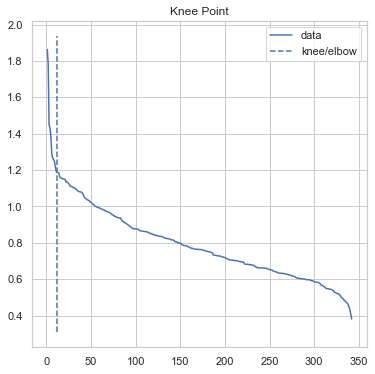

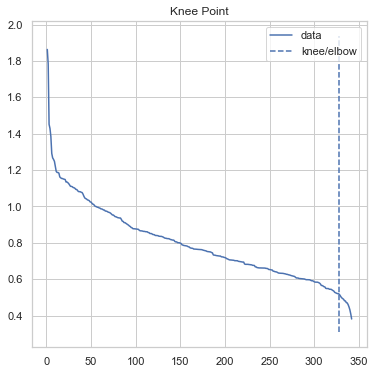

In [25]:
elbow.plot_knee()
knee.plot_knee()

Elbow is a good epsilon however it seems the knee likley overfits the data.

### Find normalized versions of elbow for possible further improvement of hypertuning epsilon

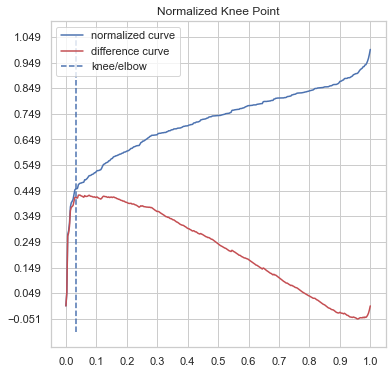

In [26]:
elbow.plot_knee_normalized()

This led to overfitting data.

### Check how DB Scan looks for non-normalized and normalized elbow and knee values

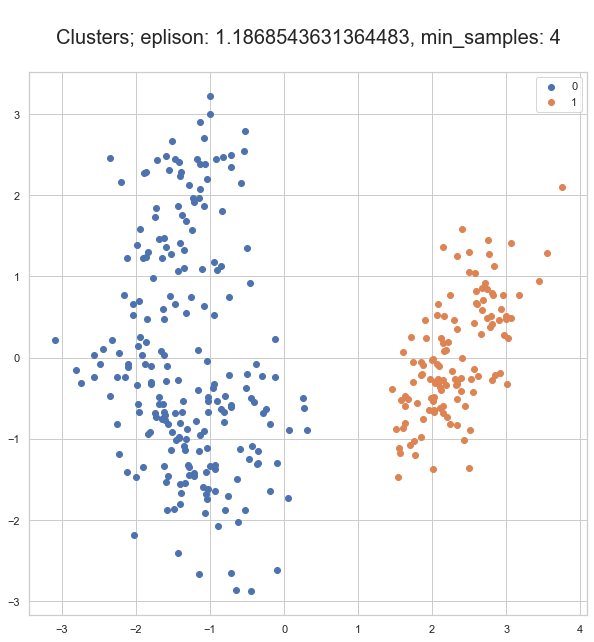

Silhouette Coefficient: 0.463


In [27]:
# Elbow
epsilon = elbow.knee_y; minimum_samples = 4
DBScan_return = DBScan_Plot_2D(penguins, epsilon, minimum_samples)
CalculateSilhouetteScore(DBScan_return, penguins)

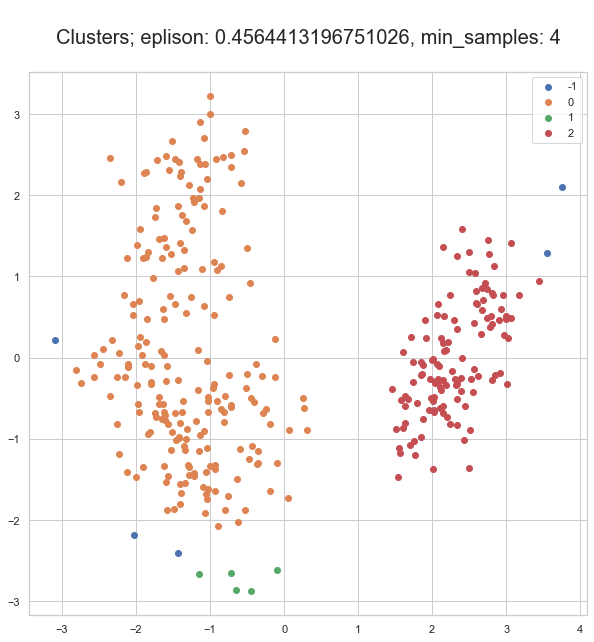

Silhouette Coefficient: 0.314


In [28]:
# Elbow normalized
epsilon = elbow.norm_knee_y; minimum_samples = 4
DBScan_return = DBScan_Plot_2D(penguins, epsilon, minimum_samples)
CalculateSilhouetteScore(DBScan_return, penguins)


In [29]:
elbow.knee_y

1.1868543631364483

Good value found for epsilon

## Function used for presentation use of DBScan graphs

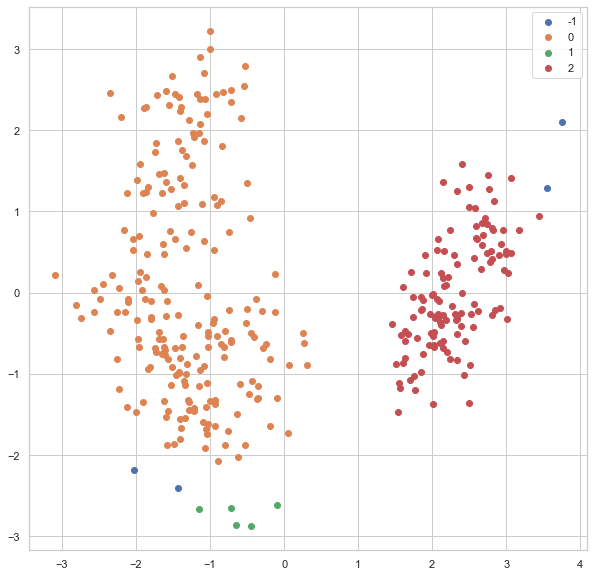

DBSCAN(min_samples=4)

In [30]:
def DBScan_Plot_2D_FullTune(dataframe, epsilon = 0.5, minimum_samples = 5):
        pca = PCA(2)
        df = pca.fit_transform(dataframe)

        db = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit(df) 
        label = db.labels_
        u_labels = np.unique(label)
        fig = plt.figure(figsize=(10, 10))
        for i in u_labels:
                plt.scatter(df[label == i,0], df[label == i, 1], label = i)
        plt.legend()
        plt.show()
        return db
        
# DBScan_Plot_2D_FullTune(penguins, 1.1868543631364483, 4)
DBScan_Plot_2D_FullTune(penguins, 0.5, 4)

<br></br>
***
***
<br></br>

# This section of the code was a self made algorithm made based on silohuette score that led to the discovery of how silohuette scores can lead ot over/under fitting and aren't always reliable when working with data that might not be well clustered.

# Self configured algorithm based on Silohuette score

In [31]:
def CalculateSilhouetteScore(DBScan_return, df):
    labels = DBScan_return.labels_
    # measure the performance of dbscan algo
    #Identifying which points make up our “core points”
    core_samples = np.zeros_like(labels, dtype=bool)
    core_samples[DBScan_return.core_sample_indices_] = True
    #Calculating "the number of clusters"
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #Computing "the Silhouette Score"
    result = 0
    if(n_clusters_ <= 1):
        result = -1
    else:
        result = metrics.silhouette_score(df, labels)
    return result

         
def FindBestSilhouette(df, epsilon_min, epsilon_max, epsilon_iterations, epsilon_samples_min, epsilon_samples_max):
    pca = PCA(2)
    df = pca.fit_transform(df)
    scoring_list = []

    epsilon_space = np.arange(epsilon_min, epsilon_max, 1/epsilon_iterations)
    min_sample_space = np.arange(epsilon_samples_min, epsilon_samples_max+1)
    for min_sample in min_sample_space:
        for epsilon in epsilon_space:
            db = DBSCAN(eps=epsilon, min_samples=min_sample).fit(df)
            score = CalculateSilhouetteScore(db, df)
            scoring_list.append([epsilon, min_sample, score])
    return pd.DataFrame(scoring_list, columns = ["epsilon", "min_samples", "Silhouette Score"]).sort_values(by=["Silhouette Score", "min_samples", "epsilon"], ascending = [False, True, True])

In [32]:
penguins_silhouette = penguins.copy()
df_silhouette = FindBestSilhouette(penguins_silhouette, .1, 1.2, 100, 2, 12)

In [33]:
firsts = df_silhouette.groupby('min_samples', as_index=False).first()
firsts.head(12)

,min_samples,epsilon,Silhouette Score
0,2,0.84,0.590605
1,3,0.84,0.590605
2,4,0.84,0.590605
3,5,0.84,0.590605
4,6,0.84,0.590605
5,7,0.84,0.590605
6,8,0.84,0.590605
7,9,0.84,0.590605
8,10,0.90,0.590605
9,11,0.90,0.590605


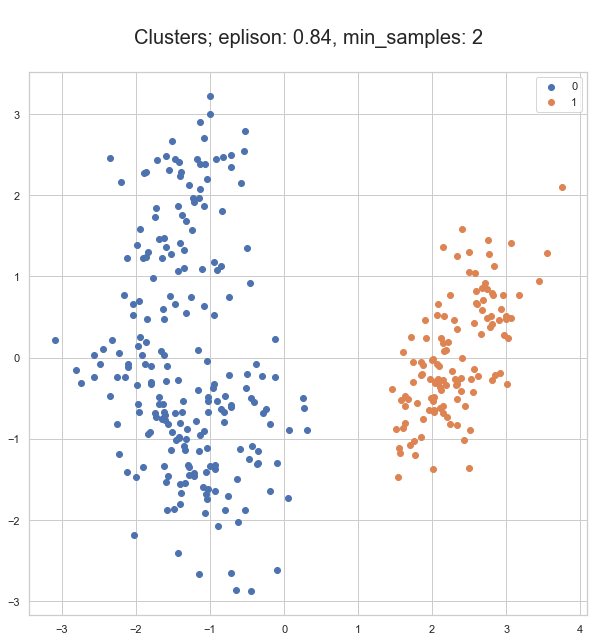

0.46295719603862867

In [34]:
epsilon = .84 ; minimum_samples = 2
DBScan_return = DBScan_Plot_2D(penguins_silhouette, epsilon, minimum_samples)
CalculateSilhouetteScore(DBScan_return, penguins_silhouette)

In [35]:
def PlotSilhouetteScores(df):
    fig, ax = plt.subplots(figsize=(18, 12))
    for key, grp in df.groupby(['min_samples']):
        ax = grp.plot(ax=ax, kind='line', x='epsilon', y='Silhouette Score', label=key)
    plt.xlabel('epsilon', fontsize=15)
    plt.ylabel('Silhouette Score', fontsize=15)
    plt.legend(loc='best',title="min_samples",fontsize=15)
    plt.title("Silohuette Scores based on epsilon and min_samples values", fontsize=20)
    plt.show()

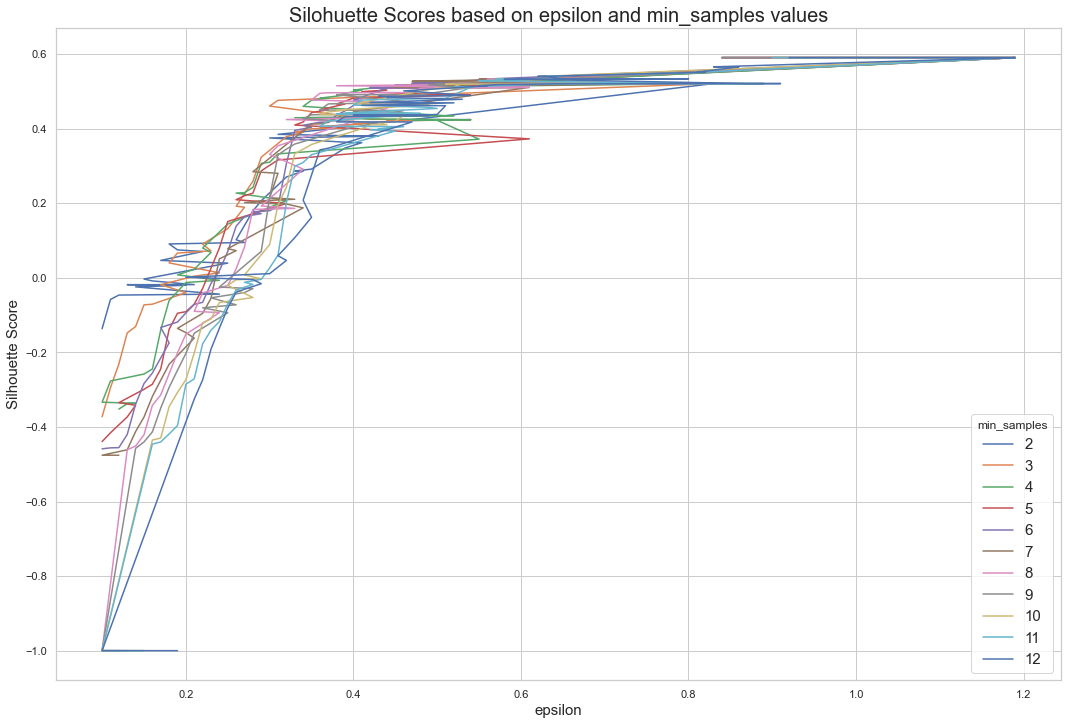

In [36]:
PlotSilhouetteScores(df_silhouette)